# Results for XGB when applying syn tranformation to both premise and hypothesis

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML 
from lr.analysis.util import get_ts_from_results_folder, get_rho_stats_from_result_list

## Accuracy

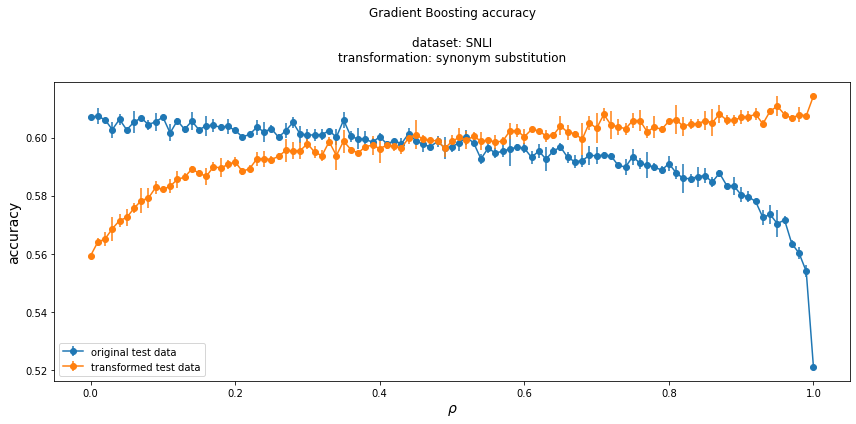

In [2]:
test_accuracy1  = get_ts_from_results_folder(path="results/snli/xgb/syn_p_h/batch1/",
                                             stat="test_accuracy")
test_accuracy2  = get_ts_from_results_folder(path="results/snli/xgb/syn_p_h/batch2/",
                                             stat="test_accuracy")

test_accuracy3  = get_ts_from_results_folder(path="results/snli/xgb/syn_p_h/batch3/",
                                             stat="test_accuracy")

transformed_test_accuracy1 = get_ts_from_results_folder(path="results/snli/xgb/syn_p_h/batch1/",
                                             stat="transformed_test_accuracy")

transformed_test_accuracy2 = get_ts_from_results_folder(path="results/snli/xgb/syn_p_h/batch2/",
                                             stat="transformed_test_accuracy")

transformed_test_accuracy3 = get_ts_from_results_folder(path="results/snli/xgb/syn_p_h/batch3/",
                                             stat="transformed_test_accuracy")


x, y, error = get_rho_stats_from_result_list([test_accuracy1, test_accuracy2, test_accuracy3])
x_t, y_t, error_t = get_rho_stats_from_result_list([transformed_test_accuracy1,
                                                    transformed_test_accuracy2,
                                                    transformed_test_accuracy3])

fig, ax = plt.subplots(figsize=(12,6))
ax.errorbar(x, y, yerr=error, fmt='-o', label="original test data");
ax.errorbar(x_t, y_t, yerr=error_t, fmt='-o', label="transformed test data");
ax.legend(loc="best");
ax.set_xlabel(r"$\rho$", fontsize=14);
ax.set_ylabel("accuracy", fontsize=14);
ax.set_title("Gradient Boosting accuracy\n\ndataset: SNLI\ntransformation: synonym substitution\n");
fig.tight_layout()
fig.savefig('figs/gb_acc_snli_syn_p_h.png', bbox_inches=None, pad_inches=0.5)

## P-values

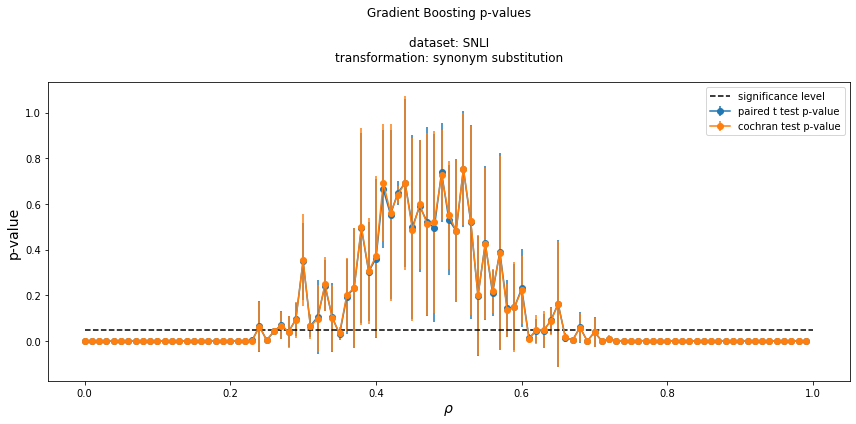

In [3]:
paired_t_p_value1  = get_ts_from_results_folder(path="results/snli/xgb/syn_p_h/batch1/",
                                             stat="paired_t_p_value")
paired_t_p_value2  = get_ts_from_results_folder(path="results/snli/xgb/syn_p_h/batch2/",
                                             stat="paired_t_p_value")

paired_t_p_value3  = get_ts_from_results_folder(path="results/snli/xgb/syn_p_h/batch3/",
                                             stat="paired_t_p_value")

cochran_p_value1 = get_ts_from_results_folder(path="results/snli/xgb/syn_p_h/batch1/",
                                             stat="cochran_p_value")

cochran_p_value2 = get_ts_from_results_folder(path="results/snli/xgb/syn_p_h/batch2/",
                                             stat="cochran_p_value")

cochran_p_value3 = get_ts_from_results_folder(path="results/snli/xgb/syn_p_h/batch3/",
                                             stat="cochran_p_value")

x, y, error = get_rho_stats_from_result_list([paired_t_p_value1,
                                              paired_t_p_value2,
                                              paired_t_p_value3])

x_t, y_t, error_t = get_rho_stats_from_result_list([cochran_p_value1,
                                                    cochran_p_value2,
                                                    cochran_p_value3])

cut = 100

fig, ax = plt.subplots(figsize=(12,6))
ax.errorbar(x[:cut], y[:cut], yerr=error[:cut], fmt='-o', label="paired t test p-value");
ax.errorbar(x_t[:cut], y_t[:cut], yerr=error_t[:cut], fmt='-o', label="cochran test p-value");
ax.hlines(0.05,x[0], x[cut], color="k", linestyles = 'dashed', label="significance level");
ax.legend(loc="best");
ax.set_xlabel(r"$\rho$", fontsize=14);
ax.set_ylabel("p-value", fontsize=14);
ax.set_title("Gradient Boosting p-values\n\ndataset: SNLI\ntransformation: synonym substitution\n");
fig.tight_layout()
fig.savefig('figs/gb_p_values_snli_syn_p_h.png', bbox_inches=None, pad_inches=0.5)

## P-values: taking a closer look

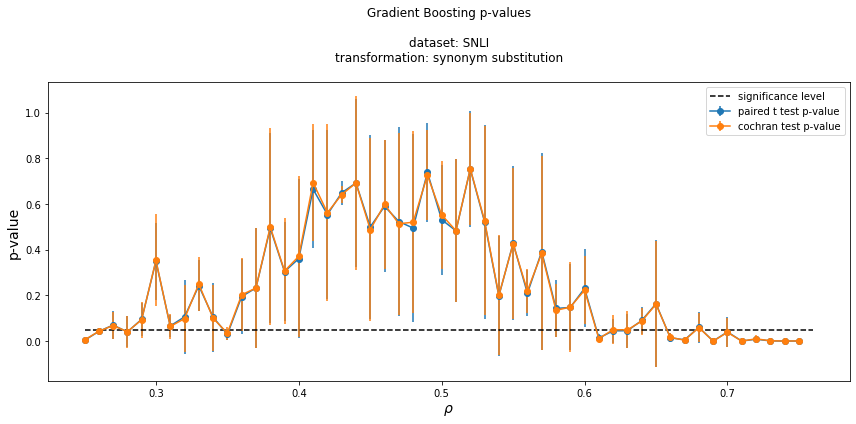

In [4]:
cut1 = 25
cut2 = 76

fig, ax = plt.subplots(figsize=(12,6))
ax.errorbar(x[cut1:cut2], y[cut1:cut2], yerr=error[cut1:cut2], fmt='-o', label="paired t test p-value");
ax.errorbar(x_t[cut1:cut2], y_t[cut1:cut2], yerr=error_t[cut1:cut2], fmt='-o', label="cochran test p-value");
ax.hlines(0.05,x[cut1], x[cut2], color="k", linestyles = 'dashed', label="significance level");
ax.legend(loc="best");
ax.set_xlabel(r"$\rho$", fontsize=14);
ax.set_ylabel("p-value", fontsize=14);
ax.set_title("Gradient Boosting p-values\n\ndataset: SNLI\ntransformation: synonym substitution\n");
fig.tight_layout()
fig.savefig('figs/gb_p_values_snli_syn_p_h_zoom.png', bbox_inches=None, pad_inches=0.5)

### Ploting the std of P-values

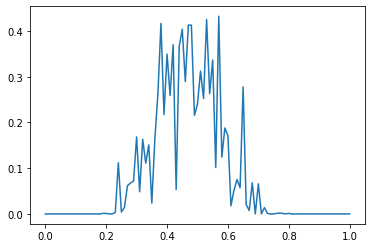

In [5]:
x, y, error = get_rho_stats_from_result_list([paired_t_p_value1,
                                              paired_t_p_value2,
                                              paired_t_p_value3])
pd.Series(error, index=x).plot();